# Final Project

## By Team VC

### Intro to Co Purchasing Network | Toy reviews

For our final, we decided our analysis will use real world data supplied from the [Amazon co-purchasing network (March 2, 2003)](https://snap.stanford.edu/data/amazon0302.html). This network consisted of over 500 millions nodes with two types of nodes: products and reviewers. Each review about a products represents an edge between a reviewer and a product. Our starter network for the analysis is the Toy reviews sub network, so our limited scope is more susceptible for visual QAs. Let's begin our analysis!


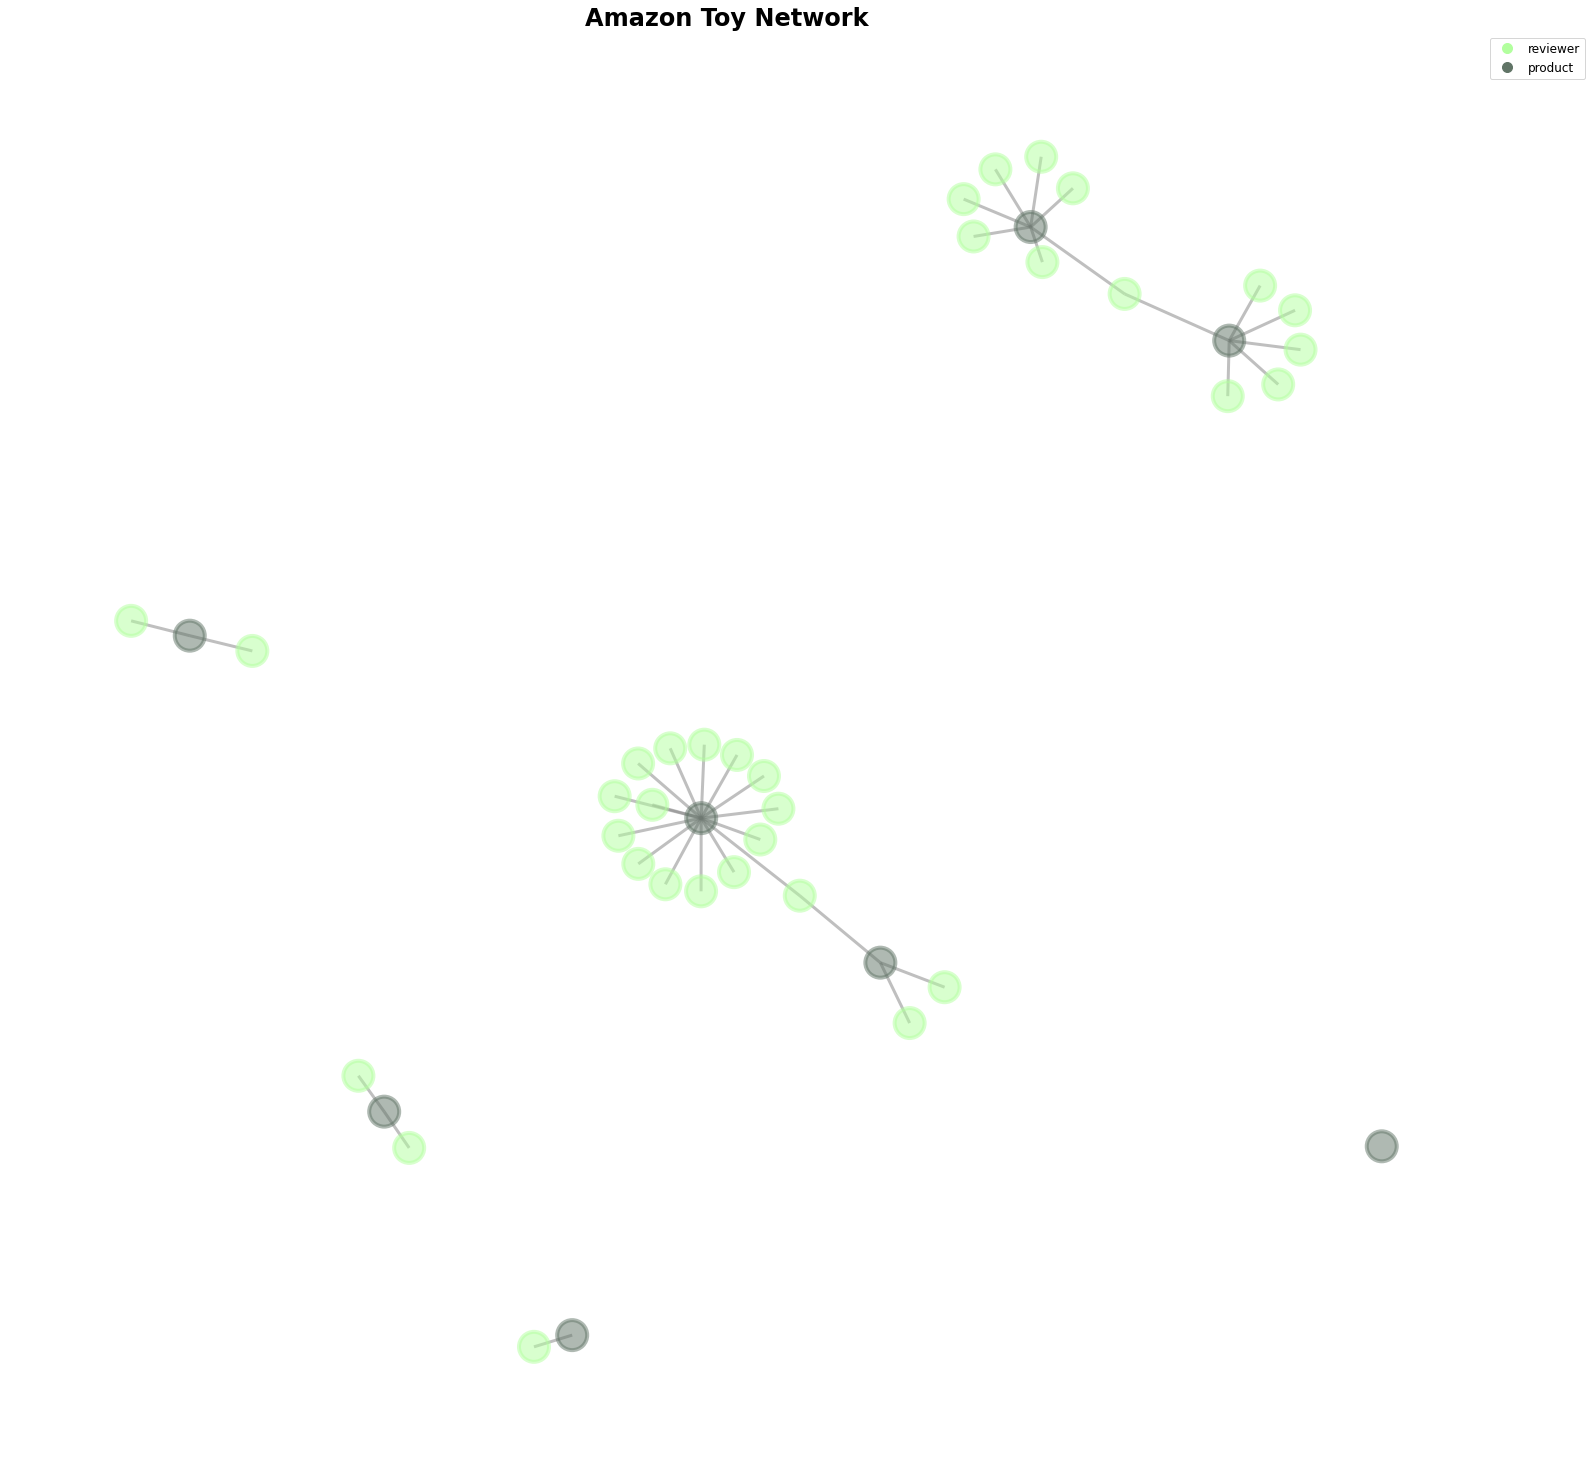

In [1]:
#Loading in our prep
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from networkx.algorithms import bipartite
import nltk
import re
import time
from sklearn.utils import shuffle


#Let's grab the product id as its label, for the cross matching later on
toy= nx.read_gml("amazon-toy.gml",label='label')
node_type=nx.get_node_attributes(toy,'type')

# Visualize the entire network
colors = []
color_map = { 'reviewer' : "#B2FF9E", 'product' : "#607466" }

for k in node_type:
    colors.append(color_map[node_type[k]])

plt.figure(figsize=(20, 20))

nx.draw(toy,
        font_size=18,
        font_weight="bold",
        font_color="black",
        node_size=900, 
        node_color=colors,
        edge_color="grey",
        node_shape="o", 
        alpha=0.5, 
        linewidths=4, 
        width=3)


legend_colors = list(color_map.values())
legend_texts = list(color_map.keys())

patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=legend_colors[i], 
            label="{:s}".format(legend_texts[i]) )[0]  for i in range(len(legend_texts)) ]
plt.legend(
           handles=patches, 
           ncol=1, 
           numpoints=1, 
           fontsize = 12, 
           loc="upper right",
           bbox_to_anchor=(1.1, 1)
          )

plt.title("Amazon Toy Network", fontdict= { 'fontsize': 24, 'fontweight':'bold'}, loc='center')

plt.show()


### Developing Our Product List

For our analysis, let's sort the 2 node types for feature gathering. We created our product data frame with nodes of type 'product' filtered by node type. In this network, we can create our product list for the rating prediction and a dataframe for our product stats. The product statistics hosts any revelant data which can train a classifier to predict the product's overall rating in Amazon's marketplace.

In [2]:
#create a function that accepts a network graph to compute 
def product_create(G):
    product_list=[]
    product_details=[]
    P_Ids=[]
    p_l=[n for n, d in G.nodes(data=True) if d['type']=='product']
    p_g=G.subgraph(p_l)

    #creating a tuple list with only the product Id and overall product rating
    for n in p_g.nodes(data=True):
        product_list.append((n[0],n[1]['average_rating']))

    #gathering all details from the product nodes, will retrieve edge data from org list
    for n in p_g.nodes(data=True):
        P_Ids.append(n[0])
        product_details.append((n[0],n[1]['salesrank'],n[1]['reviews'],n[1]['title']))

    #the beginning of the product stats
    product_stats=pd.DataFrame(product_details,columns = ['Product_Id','Sales_Rank','Review_Count','Title'])
    return product_list,product_stats,P_Ids

product_list,product_stats,p_Ids=product_create(toy)
display(product_stats.head())

,Product_Id,Sales_Rank,Review_Count,Title
0,B000059T05,4053,7,Party Tyme Karaoke CD Oldies
1,0963679600,59,16,IlluStory Book Kit
2,B000055XW3,31296,1,The Songs of Britney Spears & Christina Aguilera
3,0963679678,2288,3,Photostory Junior Book Kit
4,0963679627,45241,0,R- Photostory Senior


### Retrieval of product reviews

Now, we can focus our attention on the available reviews for the product. The edge attributes holds the reviewer's opinon on the product: the date of the review,their rating, how many people agree with their rating, and how many people found their review helpful. We can use these statistics to create more guessing metrics.  The edges stats table created three new feautres from our reviews: the most voted rating, the most helpful rating, and the earliest rating available.

Now, we can join the two tables with a inner left join!


In [3]:
#function that will retrieve edge details 
def create_edetails(G,P_Ids):
    edge_details=[]
    edge_d=[]
    p_ids_dict = { id : 1 for id in P_Ids }

#    start_time = time.time()
    #if node is a product node, return its list of edge attributes into its own list
    for n in G.nodes(data=True):
        if n[0] in p_ids_dict:  
        #if n[0] in P_Ids:  
            #grab the edges from the specific node and apprend to edge details
            edges=G.edges(n[0],data=True)
            edges=list(edges)
            edge_d.append((edges))

#    print("--- %2.f seconds for n in G.nodes ---" % (time.time() - start_time))
#    start_time = time.time()

    #In order to grab the edges features: We have to iterate down the nested list for each edge
    for e in edge_d:
        for i in range(len(e)):
            #for each value, retreive values from the nested dic
            edge_details.append((e[i][0],e[i][2]['date'],e[i][2]['rating'],e[i][2]['votes'],e[i][2]['helpful']))
#    print("--- %2.f seconds for e in edge_d ---" % (time.time() - start_time))
#    start_time = time.time()

    #display(edge_details)
    #Create the edge details table and left join with product details table by P_ID
    edge_stats=pd.DataFrame(edge_details,columns = ['Product_Id','Date','Rating','Votes','Helpful'])
#    print("--- %2.f seconds pd.DataFrame ---" % (time.time() - start_time))

    return edge_stats

edge_stats=create_edetails(toy,p_Ids)
display(edge_stats.head())

,Product_Id,Date,Rating,Votes,Helpful
0,B000075A8O,2004-3-29,5,4,4
1,B000075A8O,2004-6-19,5,3,3
2,B000055XW3,2001-2-26,3,2,2
3,0963679600,2004-7-12,5,27,25
4,0963679600,1999-6-25,5,20,20


In [4]:
#function to return top rankings based on 
def find_rates(P_Ids,e):
    p_id_dict = {pid : 1 for pid in e['Product_Id'].unique()}
    rates=[]
    #Make rate values numeric
    e['Rating'] = pd.to_numeric(e['Rating'])
    e['Votes'] = pd.to_numeric(e['Votes'])
    e['Helpful'] = pd.to_numeric(e['Helpful'])
    
    for i in range(len(P_Ids)):
        if P_Ids[i] in p_id_dict:
        #if P_Ids[i] in e.values:
            #filter for the specific product id in the table
            temp= e[e['Product_Id'] == P_Ids[i]]
            #Retrieve top values from .max and .min
            rates.append(
                (P_Ids[i],
                 temp[temp['Votes']   ==temp.max()['Votes']]['Rating'].values[0],
                 temp[temp['Helpful'] ==temp.max()['Helpful']]['Rating'].values[0],
                 temp[temp['Date']    ==temp.min()['Date']]['Rating'].values[0])
            )
        else:
        #If the Product Id has no reviews, return all zeros
            rates.append((P_Ids[i],0,0,0))

    r=pd.DataFrame(rates,columns=['Product_Id','Most_Voted_Rating','Most_Helpful_Rating','Earliest_Rating'])
    return r


In [5]:
top_rates=find_rates(p_Ids,edge_stats)
display(top_rates.head())

#combine the two tables into one
master=pd.merge(product_stats, top_rates, on="Product_Id", how="left")
display(master)

,Product_Id,Most_Voted_Rating,Most_Helpful_Rating,Earliest_Rating
0,B000059T05,1,1,4
1,0963679600,5,5,5
2,B000055XW3,3,3,3
3,0963679678,5,5,5
4,0963679627,0,0,0


,Product_Id,Sales_Rank,Review_Count,Title,Most_Voted_Rating,Most_Helpful_Rating,Earliest_Rating
0,B000059T05,4053,7,Party Tyme Karaoke CD Oldies,1,1,4
1,0963679600,59,16,IlluStory Book Kit,5,5,5
2,B000055XW3,31296,1,The Songs of Britney Spears & Christina Aguilera,3,3,3
3,0963679678,2288,3,Photostory Junior Book Kit,5,5,5
4,0963679627,45241,0,R- Photostory Senior,0,0,0
5,B000075A8O,7812,2,Party Tyme Karaoke CD Kids Songs,5,5,5
6,1572810939,1890,2,Wizard Card Game Deluxe,5,5,5
7,B000053W7W,10732,6,Party Tyme Karaoke CD: V2 Super Hits,5,5,5


### Features for predicting the products rating

In [6]:
def no_features(product):
    return {'negative_one': 1 }

def rank_and_review_count(product):
    features = {}
    features['sales_rank'] =master.loc[master.Product_Id==product,'Sales_Rank'].values[0]
    features['review_count'] =master.loc[master.Product_Id==product,'Review_Count'].values[0]
    return features

def other_ratings(product):
    features = {}
    features['most_voted_rating'] = master.loc[master.Product_Id==product,'Most_Voted_Rating'].values[0]
    features['most_helpful_rating'] = master.loc[master.Product_Id==product,'Most_Helpful_Rating'].values[0]
    features['earliest_rating'] = master.loc[master.Product_Id==product,'Earliest_Rating'].values[0]
    return features
def community_choice(product):
    features={}
    features['review_count']=master.loc[master.Product_Id==product,'Review_Count'].values[0]
    features['most_helpful_rating']= master.loc[master.Product_Id==product,'Most_Helpful_Rating'].values[0]
    features['sales_rank'] =master.loc[master.Product_Id==product,'Sales_Rank'].values[0]
    return features


all_features=[no_features,rank_and_review_count,other_ratings,community_choice]

#shuffle product ids/ratings and split for testing
data=shuffle(product_list)
train_names,test_names = data[0:4], data[4:8]


In [7]:
def run_classfiyer(train_names,test_names):
    results_list = []

            # For each feature function, try to classify the test sets
    for fn in all_features:
        train_set = [(fn(n), g) for (n,g) in train_names]
        test_set = [(other_ratings(n), g) for (n,g) in test_names]

                # make a classifier from the training set
        classifier =nltk.NaiveBayesClassifier.train(train_set)

                # Print the classifier logic
        accuracy_train = nltk.classify.accuracy(classifier, train_set)
        accuracy_test = nltk.classify.accuracy(classifier, test_set)

        results_list.append([fn.__name__, accuracy_train, accuracy_test])


        results_df = pd.DataFrame(results_list,
                                      columns=['Function', 
                                               'Training Accuracy', 
                                               'Test Accuracy',
                                               ])

    return results_df.head()

run_classfiyer(train_names,test_names)

,Function,Training Accuracy,Test Accuracy
0,no_features,1.0,0.0
1,rank_and_review_count,1.0,0.0
2,other_ratings,1.0,0.0
3,community_choice,1.0,0.0


### Expanding our learning into a larger network | DVD reviews

In [8]:
start_time = time.time()
dvds = nx.read_gml("amazon-dvd.gml")
print("--- %2.f seconds to read gml file ---" % (time.time() - start_time))


--- 75 seconds to read gml file ---


In [9]:
#Following the steps from the toy network, let's create dvd's feature table
dvd_list,dvd_stats,dvd_Ids=product_create(dvds)
display(dvd_stats.head())

,Product_Id,Sales_Rank,Review_Count,Title
0,B00005JKYX,6853,218,The Scorpion King (Widescreen Collector's Edit...
1,630530887X,22997,12,Burglar
2,B00005YUPH,40516,1,The Soultaker - Flickering Faith (Vol. 2)
3,B00000I1SE,46244,34,Tokyo Babylon Vols 01 & 02
4,B0000648X3,19515,12,Roughnecks - The Starship Troopers Chronicles ...


In [10]:
#create dvd edge info table
edvd_stats=create_edetails(dvds,dvd_Ids)
display(edvd_stats.head())

,Product_Id,Date,Rating,Votes,Helpful
0,0790747324,1998-12-27,5,1,1
1,0790747324,2002-4-5,4,4,3
2,0790747324,1999-4-19,4,6,6
3,0790747324,1999-5-11,5,1,1
4,0790747324,1999-6-9,5,2,2


In [11]:
#find all the available ratings for the dvd network
#Will reduce our dvd Ids list for time consumption, cannot run on all 26K Products in the network 
start_time = time.time()
reduce_Ids=dvd_Ids[:5000]

#prepare the product pool to only include the Ids we kept
re_list = [x for x in dvd_list if x[0] in reduce_Ids]

#find the top rates
t_rates=find_rates(reduce_Ids,edvd_stats)
display(t_rates.head())


,Product_Id,Most_Voted_Rating,Most_Helpful_Rating,Earliest_Rating
0,B00005JKYX,5,4,4
1,630530887X,1,3,5
2,B00005YUPH,4,4,4
3,B00000I1SE,5,5,5
4,B0000648X3,5,5,5


In [23]:
#combine the two tables into one
#master=pd.merge(edvd_stats, t_rates, on="Product_Id", how="left")

#drop rows that where removed from the product reduction
#master=master[master['Product_Id'].isin(re_list)]
#master.reset_index(drop=True)
#display(master)

,Product_Id,Date,Rating,Votes,Helpful,Most_Voted_Rating,Most_Helpful_Rating,Earliest_Rating


### Final takeaways